Names: Guy Cohen, Shahar Amram

IDs: 206463606, 205457898

### The objective of this assignment is to develop a predictive model using the AdaBoost algorithm to determine whether a patient has heart disease or not. We have a dataset containing various features related to patients, and based on these features, we will train an AdaBoost classifier to make accurate predictions.

In [1598]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Load the csv file.
def load_data():
    data = pd.read_csv("heart_disease.csv")
    return data
    # Shuffle the data.
    # shuffled_data = data.sample(frac=1).reset_index(drop=True)
    # return shuffled_data

# Standardize the data.
# def standardize(data):
#     # Seperate the feateres in 'x' and 'target' in y
#     x = data.drop(["target"],axis = 1)
#     y = data["target"]
#     # normalize
#     scaler = StandardScaler()
#     X = scaler.fit_transform(x)
#     X = np.clip(X,-3,3)
#     return X, y


# Standardize the data.
def standardize(data):
    # Seperate the feateres in 'x' and 'target' in y
    x = data.drop(["target"],axis = 1)
    y = data["target"]
    # normalize
    x_mean = np.mean(x,axis=0)
    x_std = np.std(x,axis=0)
    x_std[x_std == 0] = 1e-8
    x=(x-x_mean)/x_std
    x[x > 3] = 3
    x[x < -3] = -3
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    return x, y

# plot the data.
def plot_data(data):
    X = data.drop(["target"],axis = 1)
    y = data["target"]
    # Create a DataFrame from X and y
    columns = data.columns.drop('target')
    X_df = pd.DataFrame(X, columns=columns)
    X_df['target'] = y
    # Plot the data
    plt.scatter(x=X_df.age[X_df.target == 1], y=X_df.thalach[X_df.target == 1], c="red", s=10, linewidths=1.5)
    plt.scatter(x=X_df.age[X_df.target == 0], y=X_df.thalach[X_df.target == 0], c="blue" ,s=10, linewidths=2.5)
    plt.legend(["Disease", "Not Disease"])
    plt.xlabel("Age")
    plt.ylabel("Maximum Heart Rate")
    plt.title('Heart Disease Frequency for Ages')
    plt.show()
  
    

## AdaBoost model

In [1599]:
# Dicison stump with one node
class DecisionStump():
    #  Initializes the attributes of the DecisionStump object.
    def __init__(self):
        # positive or negative.
        self.polarity = 1
        # the index of the feature on which the decision stump will be based.
        self.feature_idx = None
        # the threshold value used to make the decision.
        self.threshold = None
        # Alpha is the learning rate (expert).
        self.alpha = None


# Algoorithm adaboost.
class Adaboost():
    # Initializes the attributes of the Adaboost object.
    def __init__(self, n_clf=50):
        # Number of stumps
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = X.shape
        """
        n_samples = m
        n_features = n
        """
        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = [] 

        # Iterate through classifiers
        for _ in range(self.n_clf):
            # Initialize the minimum error as infinity.
            min_error = float('inf')
            clf = DecisionStump()

            # Find the best h_t that minimizes the error, according to the weights, W_i_t.
            for feature_i in range(n_features):
                # Features vector
                X_column = X[:, feature_i]

                thresholds = np.unique(X_column,axis=None)

                for threshold in thresholds:
                    # Predict with polarity 1
                    p = 1
                    h_t = np.ones_like(y)

                    # If it smaller than threshold => -1
                    h_t[X_column <= threshold] = -1

                    # Error = sum of weights that h_t wrong.
                    error = np.sum(w[h_t != y])

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # Store the best configuration -> Store the smallest error.
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # Calculate alpha: the amount of samples that h_t got wrong
            clf.alpha = 0.5 * np.log((1 - min_error) / min_error + 1e-10)

            # Initialzie the h-t
            h_t = np.full_like(y,clf.polarity)

            # Update the h-t according to the threshold
            h_t[X[:,clf.feature_idx] <= clf.threshold] *= -1

            # Update the weight in place (t+1), the new one
            w *= np.exp(-clf.alpha * y * h_t)

            # Wi(t+1)= Wi(t+1)/(sigma(Wi(t+1))), normalizing of Wi(t+1) -> The sum of weights is 1.
            Z = np.sum(w , axis=None)
            w /= Z

            # Add each stump to the list of classifiers
            self.clfs.append(clf)
            


    # H(x) = sign(alpha_1 * h_1(x) + alpha_2 * h_2(x) + ... + alpha_t * h_t(x))
    def predict(self, X):
        # Initializes an array H of zeros with the same number of rows as the input data X.
        H = np.zeros((X.shape[0],))
        # For each stump
        for i in self.clfs:
            # Initializes an array _h_t with the same shape as H, filled with the polarity value of the current weak classifier i
            _h_t = np.full((X.shape[0],), i.polarity)
            # For each sample in x
            for j in range(X.shape[0]):
                #  If the feature value of the current data point is less than or equal to the threshold
                if X[j, i.feature_idx] <= i.threshold:
                    _h_t[j] *= -1
            # Updates the array H
            H += i.alpha * _h_t
        # Returns the sign of the array H
        return np.sign(H)



## Loading and Displaying Data

In [1600]:
data = load_data()
data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


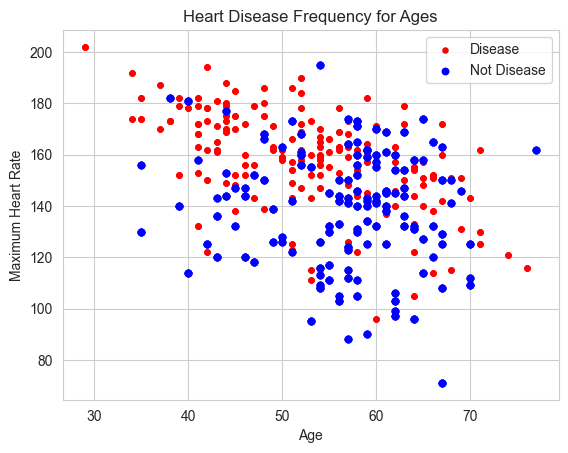

In [1601]:
plot_data(data)


In [1602]:
# Standardize the data.
X, y = standardize(data)

# Check that the data is normalized correctly
print("X means: ", np.mean(X) )
print("X stds: ", np.std(X) )

# Make a copy of y and change values from 0 to -1
y_copy = y.copy()
y_copy[y_copy == 0] = -1

# 20% from the data will be used for test
train_x, test_x, train_y, test_y = train_test_split(X, y_copy, test_size = 0.2)
train_x1 = train_x
test_x1 = test_x
train_y1 = train_y
test_y1 = test_y


X means:  -6.665504087805818e-19
X stds:  1.0


# AdaBoost

In [1603]:

# Calling the model Adaboost that we created
clf = Adaboost(n_clf = 50)
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
acc = accuracy_score(test_y, y_pred) * 100
print("Test Accuracy of Adaboost Algorithm: {:.2f}%".format(acc))


# Built-in AdaBoost
clf_sklearn = AdaBoostClassifier(n_estimators=50)
clf_sklearn.fit(train_x, train_y)
y_pred_sklearn = clf_sklearn.predict(test_x)
acc_sklearn = accuracy_score(test_y, y_pred_sklearn)
print("sklearn AdaBoost Accuracy:", acc_sklearn)
accuracies={}
accuracies['Adaboost'] = acc

Test Accuracy of Adaboost Algorithm: 86.34%
sklearn AdaBoost Accuracy: 0.8878048780487805


# KNN

In [1604]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 8)  
knn.fit(train_x1, train_y1)
prediction = knn.predict(test_x1)
acc = knn.score(test_x1, test_y1) * 100

print("Test Score of KNN: {:.2f}%".format(acc))

Test Score of KNN: 83.90%


## Compare between Adaboost and KNN

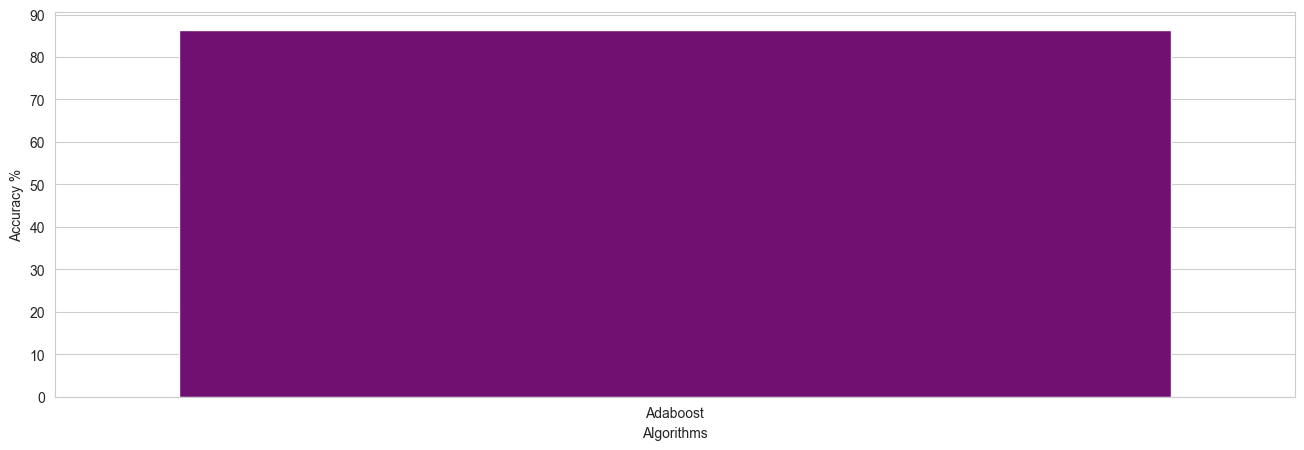

In [1605]:
import seaborn as sns
colors = ["purple", "green"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

Influence of parameters on the data